In [1]:
import csv
import numpy as np
import pandas as pd
import utils 
from copy import deepcopy
import seaborn as sns

from scipy.optimize import minimize, LinearConstraint
from scipy.special import softmax

In [2]:
data = np.genfromtxt('repeated_data.csv', delimiter=',', dtype=str)
data = np.delete(data, 0, 0)

In [3]:
new_data = []

# turn each game into entry in this array

def remove_blank(l):
    return list(filter(lambda a: a != '', l))

def replace_letters(l):
   return [[1,0] if x=='c' else [0, 1] for x in l]

for i in range(0, data.shape[0], 2):
    p1 = data[i]
    p2 = data[i+1]

    game = int(p1[0])
    player1 = p1[2]
    player2 = p2[2]
    p1_actions = np.array(replace_letters(remove_blank(p1[3:]))).T
    p2_actions =  np.array(replace_letters(remove_blank(p2[3:]))).T
   
    actions =  [p1_actions, p2_actions]

    new_data.append([game, player1, player2, actions])

In [4]:
df = pd.DataFrame(new_data)
df.columns = ['Game', 'Player_1', 'Player_2', 'Actions']

In [5]:
df.head()

,Game,Player_1,Player_2,Actions
0,0,Faisal,Bharathvaj,"[[[0, 1, 1, 1, 0], [1, 0, 0, 0, 1]], [[1, 0, 1..."
1,1,Yuan,Dagmar,"[[[1, 0, 0], [0, 1, 1]], [[1, 1, 0], [0, 0, 1]]]"
2,2,Ehsan,Mohammend,"[[[1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0], [0, 0,..."
3,3,Tao,Rohini,"[[[0, 1, 0, 1, 1], [1, 0, 1, 0, 0]], [[1, 0, 0..."
4,4,Anita,Greg,"[[[1, 1, 0, 1, 1, 1, 0], [0, 0, 1, 0, 0, 0, 1]..."


In [6]:
data = list(df.Actions)

In [7]:
from tqdm import tqdm

In [8]:
def ll_uniform(dataset):
    ll = 0
    for play in dataset: 
        for player in range(2):
            traj = play[player]
            s = np.ones(2) / 2
            
            L = traj.shape[1] #length of trajectory
            for l in range(L):
                idx = np.where(traj[:, l])
                ll += np.log(s[idx[0][0]])
        
    return -ll

In [9]:
def k_folds(data, m):
    results = []
    test_losses = []
    for i in range(len(data)):
        train_data = deepcopy(data)
        test_data = deepcopy(train_data[i])
        del train_data[i]

        res = m.fit(train_data)
        params = res.x
        test_loss = m.log_likelihood(params, [test_data])
        results.append(res)
        test_losses.append(test_loss)

    return results, test_losses


In [10]:
# K-folds on level k
from models import Level_K_Model

all_lk = []
for k in tqdm(range(0, 4)):
    m = Level_K_Model(k)
    results_LK, LL_LK =  k_folds(data, m)
    all_lk.append([results_LK, LL_LK])
        

100%|██████████| 4/4 [02:17<00:00, 34.28s/it]


In [22]:
from models import Temporal_Level_Model

m = Temporal_Level_Model()
results_TLM, LL_TLM = k_folds(data, m)
        

In [23]:
from models import Temporal_Model

m = Temporal_Model()
results_TM, LL_TM = k_folds(data, m)

In [31]:
import matplotlib.pyplot as plt

In [44]:
# results on all train data

# K-folds on level k
from models import Level_K_Model
results = []
models = []


for k in tqdm(range(0, 4)):
    m = Level_K_Model(k)
    r = m.fit(data)
    results.append(r)
    models.append(m)
    
m =  Temporal_Level_Model()
r = m.fit(data)
results.append(r)
models.append(m)

m = Temporal_Model()
r = m.fit(data)
results.append(r)
models.append(m)



100%|██████████| 4/4 [00:15<00:00,  3.84s/it]


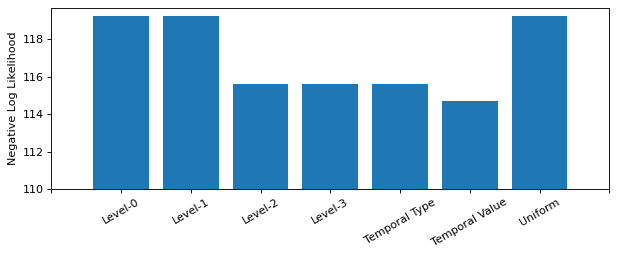

In [67]:
from matplotlib.pyplot import figure

figure(figsize=(9, 3), dpi=80)

plt.bar( range(len(results)+1),  [r.fun-110 for r in results] + [ll_uniform(data)-110], bottom=110)
plt.ylabel("Negative Log Likelihood")

locs, labels = plt.xticks()
labels = [''] + [  'Level-{}'.format(k) for k in range(4)]
labels += ['Temporal Type', 'Temporal Value', 'Uniform', '']
plt.xticks(locs, labels , rotation=30  )

plt.savefig('figures/ll_train.pdf', bbox_inches='tight')

In [37]:
#uniform
results_uniform = []
test_losses_uniform = []
for i in range(len(data)):
    train_data = deepcopy(data)
    test_data = deepcopy(train_data[i])
    del train_data[i]

    results_uniform.append(ll_uniform(train_data))
    test_losses_uniform.append(ll_uniform([test_data]))

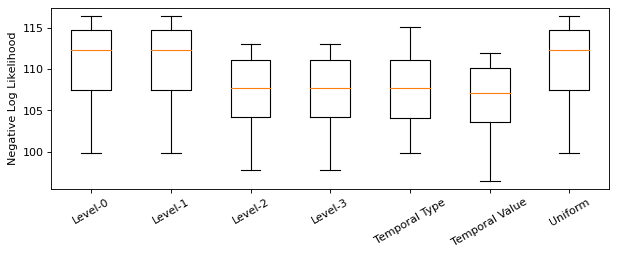

In [69]:
all_results = all_lk + [[results_TLM, LL_TLM] ,[results_TM, LL_TM], ]

plot_data = []
for r in all_results:
    result_list = r[0]


    train_losses = [x.fun for x in result_list]

    plot_data.append(train_losses)

plot_data.append(results_uniform)

figure(figsize=(9, 3), dpi=80)
plt.boxplot(plot_data)
plt.ylabel("Negative Log Likelihood")

locs, labels = plt.xticks()
labels = ['Level-{}'.format(k) for k in range(4)]
labels += ['Temporal Type', 'Temporal Value', 'Uniform']
plt.xticks(locs, labels , rotation=30  )

plt.savefig('figures/ll_train_cross.pdf', bbox_inches='tight')

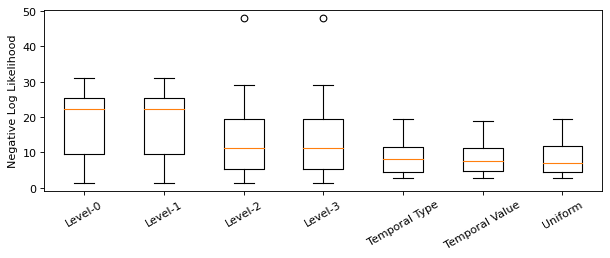

In [70]:
all_results = all_lk + [[results_TLM, LL_TLM] ,[results_TM, LL_TM], ]

plot_data = []
for r in all_results:
    result_list = r[1]
    plot_data.append(result_list)

plot_data.append(test_losses_uniform)
figure(figsize=(9, 3), dpi=80)
plt.boxplot(plot_data)
plt.ylabel("Negative Log Likelihood")

locs, labels = plt.xticks()
labels = ['Level-{}'.format(k) for k in range(4)]
labels += ['Temporal Type', 'Temporal Value', 'Uniform']
plt.xticks(locs, labels , rotation=30)


plt.savefig('figures/ll_test_cross.pdf', bbox_inches='tight')